#  Прогнозирование заказов такси

**Описание проектной работы**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

**Цель проекта**

Необходимо построить модель машинного обучения для предсказания количества заказов такси на следующий час в период пиковой нагрузки.

Значение метрики `RMSE` на тестовой выборке должно быть не больше `48`.

**Ход выполнения работы**

1. Загрузка данных и ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей.
4. Проверка наилучшей модели на тестовой выборке.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Cтационарность-ряда" data-toc-modified-id="Cтационарность-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Cтационарность ряда</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разности временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Создание-выборок" data-toc-modified-id="Создание-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание выборок</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Обучение-модели-с-помощью-дерева-решений-в-регрессии." data-toc-modified-id="Обучение-модели-с-помощью-дерева-решений-в-регрессии.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели с помощью дерева решений в регрессии.</a></span></li><li><span><a href="#Обучение-модели-с-помощью-случайного-леса-в-регрессии" data-toc-modified-id="Обучение-модели-с-помощью-случайного-леса-в-регрессии-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Обучение модели с помощью случайного леса в регрессии</a></span></li><li><span><a href="#Обучение-с-помощью-CatBoost" data-toc-modified-id="Обучение-с-помощью-CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Обучение с помощью CatBoost</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

[Назад к содержанию](#Содержание)

In [1]:
# импорт библиотек:

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# настройки

# включим возможность отображения всех столбцов в датафреймах:
pd.set_option('display.max_columns', None)

# зададим random_state:
RANDOM_STATE = 42

# отключение вывода некоторых ошибок:
pd.options.mode.chained_assignment = None

In [3]:
# формирование исходного датафрейма

df = pd.read_csv('/datasets/taxi.csv')
print('Датафрейм сформирован!')

Датафрейм сформирован!


In [4]:
# вывод общей информации о датафрейме:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# вывод первых строк:

df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
# вывод последних строк:

df.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [7]:
# проверка типа данных:

df.dtypes

datetime      object
num_orders     int64
dtype: object

In [8]:
# приведем признак datetime к формату datetime64:

df['datetime'] = pd.to_datetime(df['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [9]:
# установка индекса таблицы, равному столбцу datetime:

df = df.set_index('datetime')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [10]:
# проверка на хронологический порядок расположения даты и времени:

df = df.sort_index()
print(df.index.is_monotonic)

print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


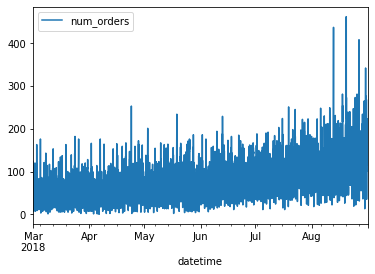

In [11]:
# ресемплирование ряда по одному часу:

df = df.resample('1H').sum()
df.plot();

Начиная с августа и по сентябрь можно отметить всплекс заказов. Скорее всего это связано с отпусками. 

In [12]:
# проверка:

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


На данном этапе загрузили исходный датафрейм, вывели несколько первых строк, убедились в хронологической правильности предоставленных данных и выполнили ресемплирование по одному часу.

Предоставлены данные за полгода: с `2018-03-01` по `2018-08-31`. 

## Анализ

[Назад к содержанию](#Содержание)

Проанализируем полученный датафрейм. 

In [14]:
# поиск пропусков:

df.isna().sum()

num_orders    0
dtype: int64

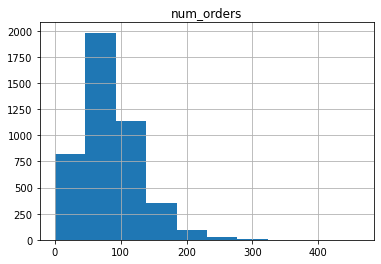

In [15]:
# гистограмма распределения заказов:

df.hist();

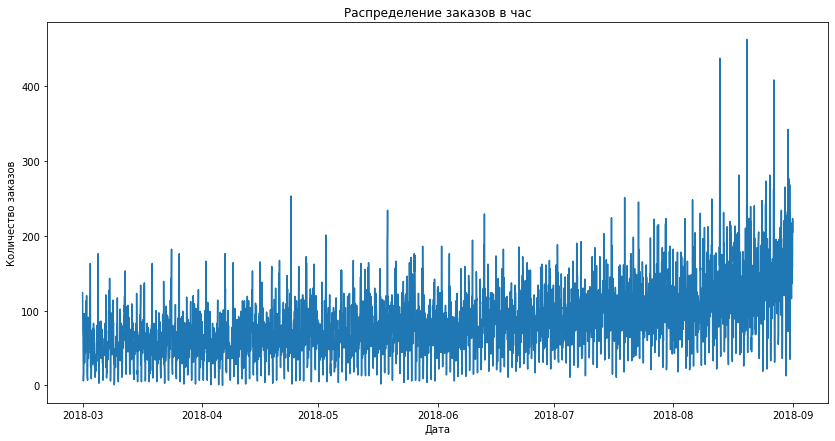

In [16]:
# график зависимости количества заказов в час:

plt.figure(figsize=(14, 7))
plt.plot(df)
plt.title('Распределение заказов в час')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Проанализируем следующие параметры:

   - скользящее среднее;
   - тренды и сезонность;
   - стационарность ряда;
   - разности временного ряда.

### Скользящее среднее

[Назад к содержанию](#Содержание)

Чтобы во временном ряду снизить колебания, применим `скользящее среднее` с размером окна, равным `24 часа`.

In [17]:
df_rolling = df.copy()

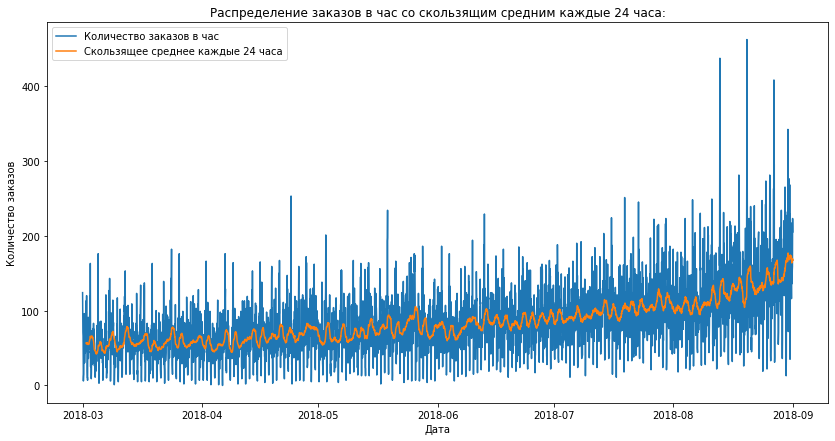

In [18]:
# вывод распределения заказов в час с учетом скользящего среднего:

plt.figure(figsize=(14, 7))
df_rolling['rolling_mean'] = df_rolling.rolling(24).mean()

plt.plot(df_rolling)
plt.title('Распределение заказов в час со скользящим средним каждые 24 часа:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Рассмотрим интервал в один месяц с `2018-08-01` по `2018-08-31`.

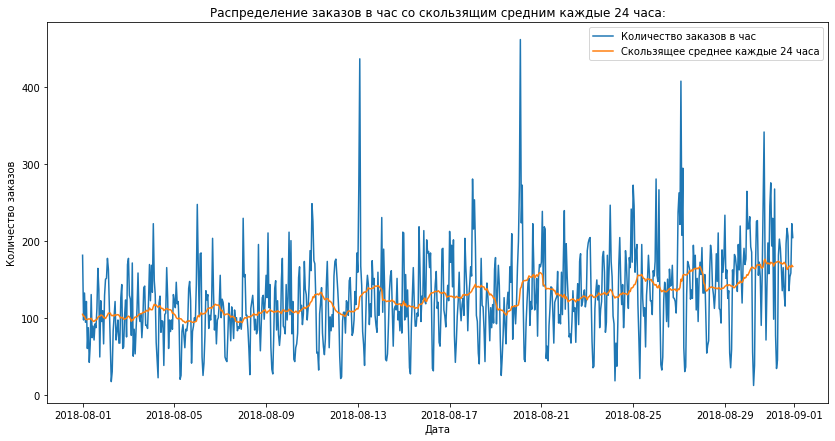

In [19]:
# вывод распределения заказов в час с учетом скользящего среднего:

plt.figure(figsize=(14, 7))
df_rolling['rolling_mean'] = df_rolling.rolling(24).mean()

plt.plot(df_rolling['2018-08-01':'2018-08-31'])
plt.title('Распределение заказов в час со скользящим средним каждые 24 часа:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Тренды и сезонность

[Назад к содержанию](#Содержание)

Разложим временной ряд на три составляющие: `тренд`, `сезонность` и `остаток`. Выведем графики получившихся составляющих.

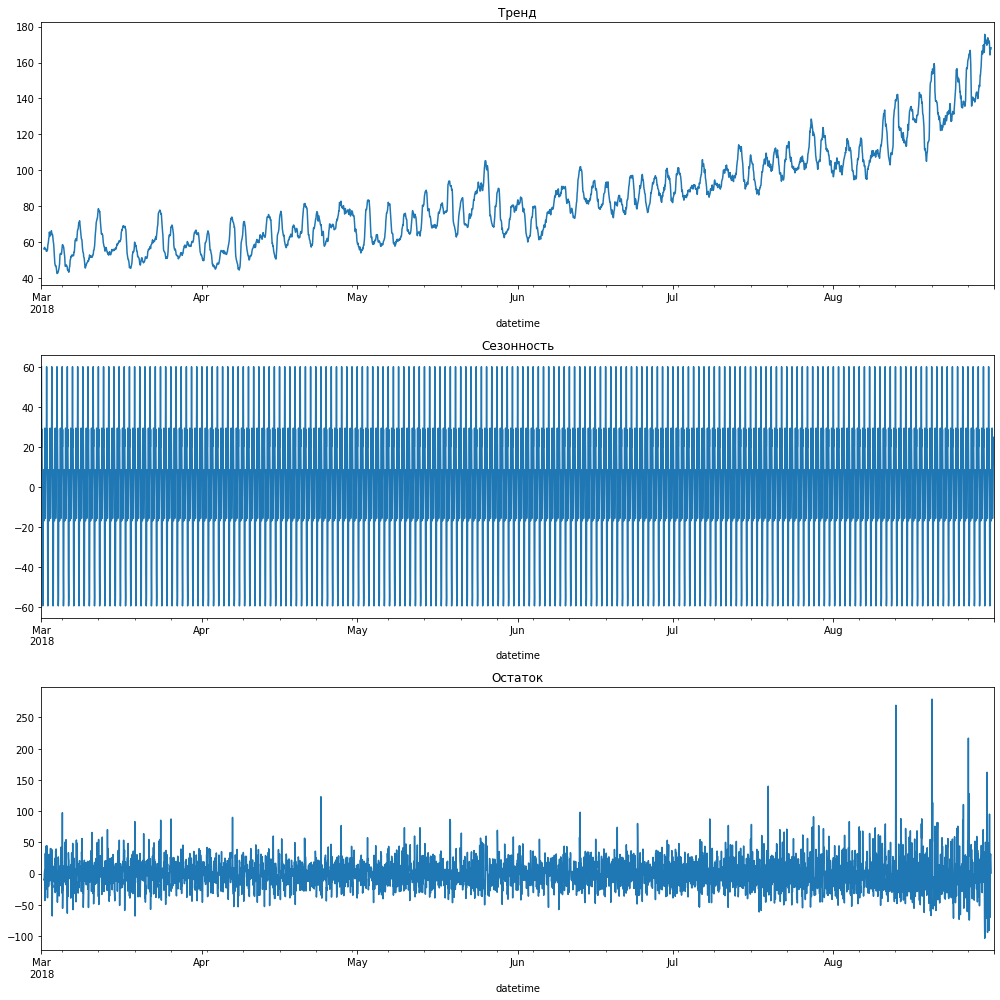

In [20]:
# разложение ряда на тренд, сезонность и остаток

decomposed = seasonal_decompose(df)

plt.figure(figsize=(14, 14))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Увеличим масштаб. Рассмотрим первые две недели ряда: с `2018-03-01` по `2018-03-15`.

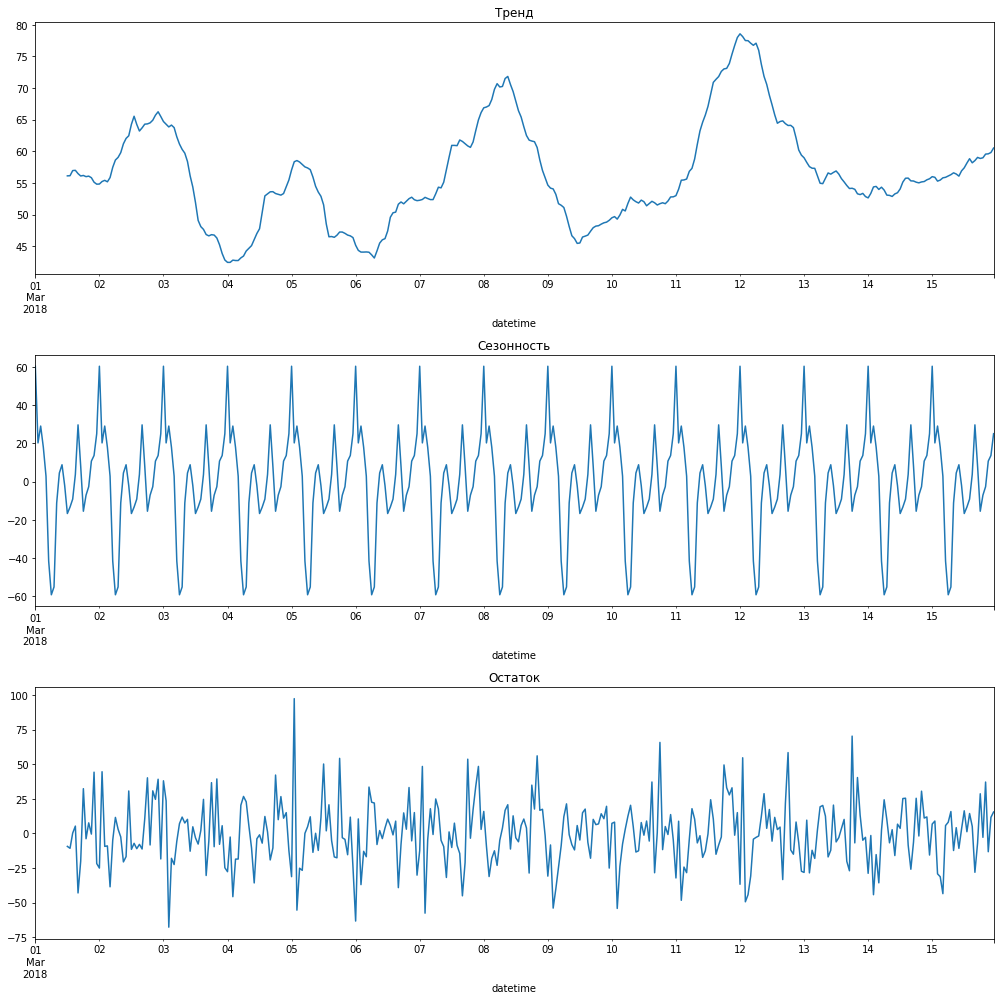

In [21]:
# графики за период с 2018-03-01 по 2018-03-15:

plt.figure(figsize=(14, 14))
plt.subplot(311)

decomposed.trend['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Тренд постепенно растет. Сезонность похожа на стационарный стохастический процес. 

Теперь рассмотрим последние две недели ряда: с `2018-08-15` по `2018-08-31`.

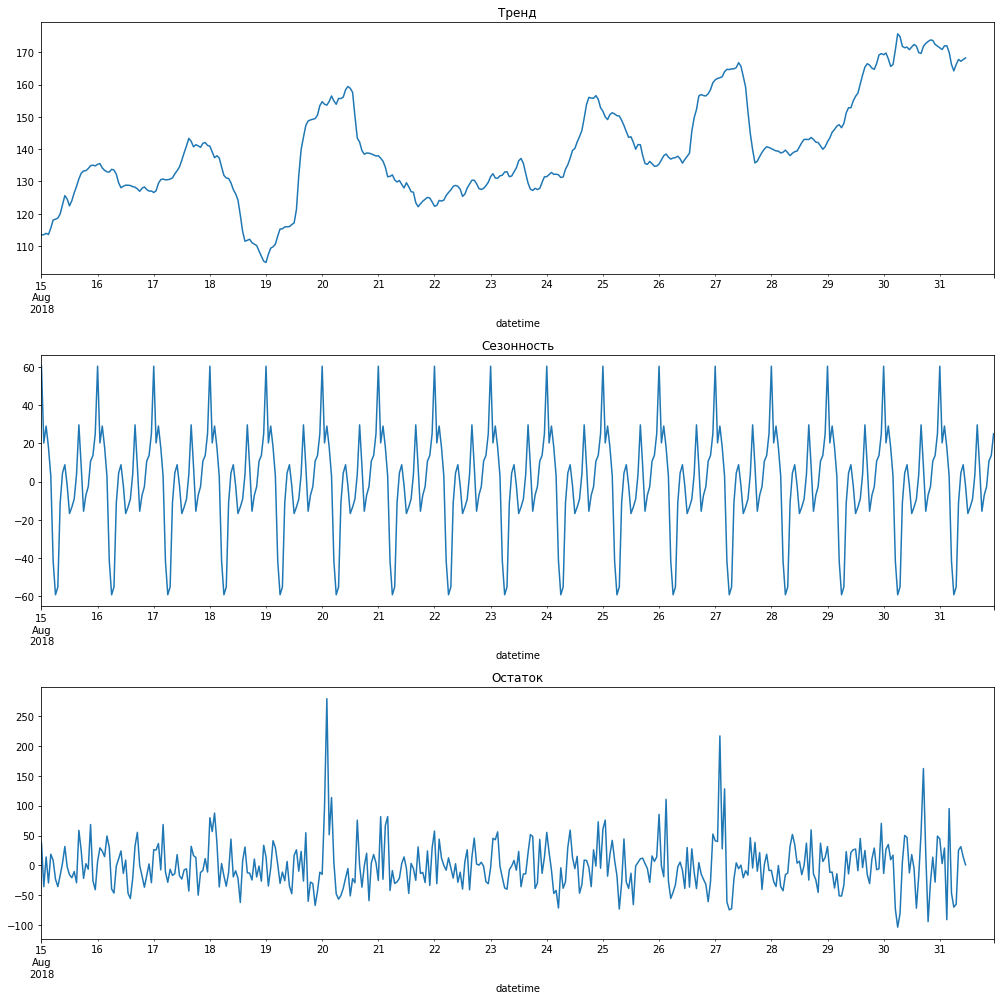

In [22]:
# графики за период с 2018-08-15 по 2018-08-31:

plt.figure(figsize=(14, 14))
plt.subplot(311)

decomposed.trend['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()




По-прежнему тренд растет. Сезонность похожа на стационарный стохастический процес.

### Cтационарность ряда

[Назад к содержанию](#Содержание)

Стохастический процесс стационарный, если его распределение со временем не меняется. Узнать распределение временного ряда нельзя. Поэтому стационарные временные ряды — это ряды, у которых среднее и стандартное отклонение не меняются.

Выведем график со скользящем стандартным отклонением и стандартным отклонением.

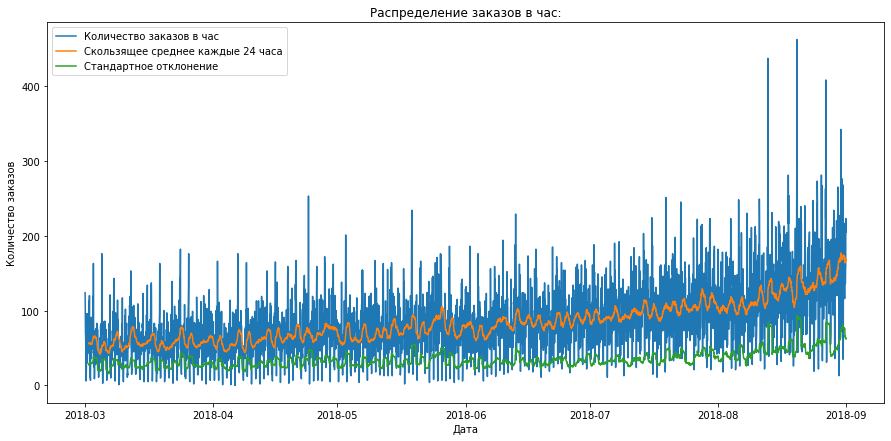

In [23]:
# график со скользящем и стандартным отклонениями:

plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean())
plt.plot(df.rolling(24).std())

plt.title('Распределение заказов в час:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

По графику сделаем вывод, что ряд стационарен для периода с `2018-03` по `2018-08`. Начиная с `2018-08` и до окончания периода ряд не стационарен.

### Разности временного ряда

[Назад к содержанию](#Содержание)

Построим график с разностью значений временного ряда.

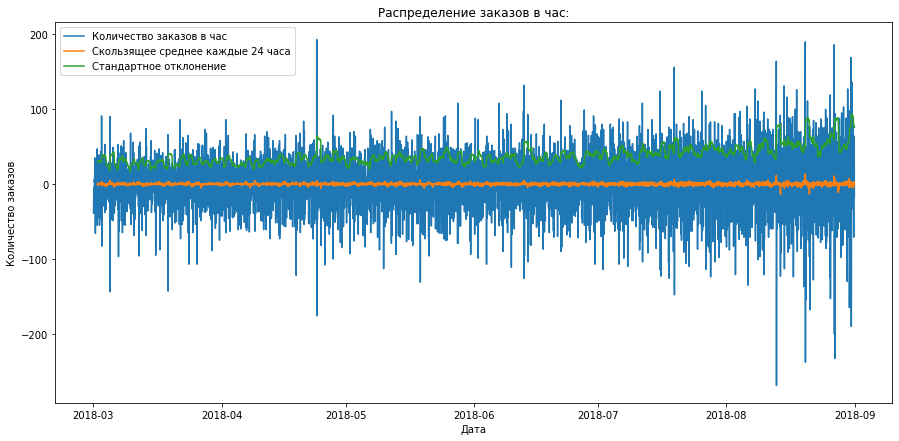

In [24]:
# разность временного ряда:

df_shift = df - df.shift()

plt.figure(figsize=(15, 7))

plt.plot(df_shift)
plt.plot(df_shift.rolling(24).mean())
plt.plot(df_shift.rolling(24).std())

plt.title('Распределение заказов в час:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

Увеличим масштаб. Рассмотрим первые две недели ряда: с `2018-03-01` по `2018-03-15`.

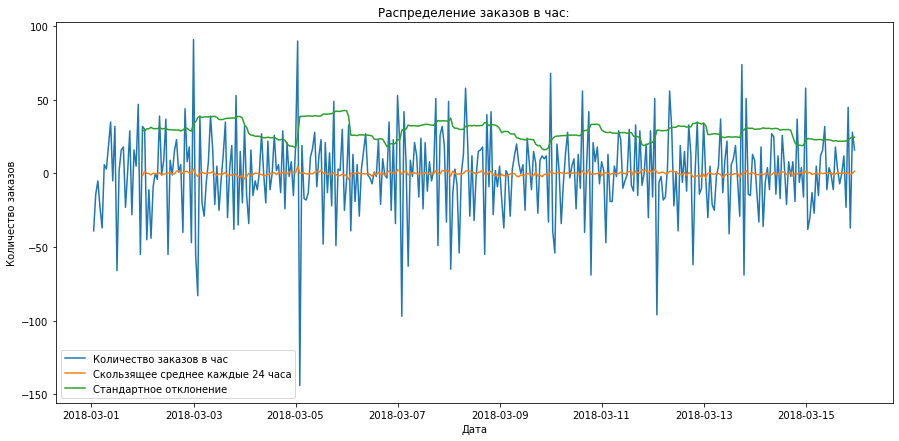

In [25]:
# разность временного ряда с 2018-03-01 по 2018-03-15:

df_shift = df - df.shift()

plt.figure(figsize=(15, 7))

plt.plot(df_shift['2018-03-01':'2018-03-15'])
plt.plot(df_shift['2018-03-01':'2018-03-15'].rolling(24).mean())
plt.plot(df_shift['2018-03-01':'2018-03-15'].rolling(24).std())

plt.title('Распределение заказов в час:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

Теперь посмотрим на последние две недели: с `2018-08-15` по `2018-08-31`.

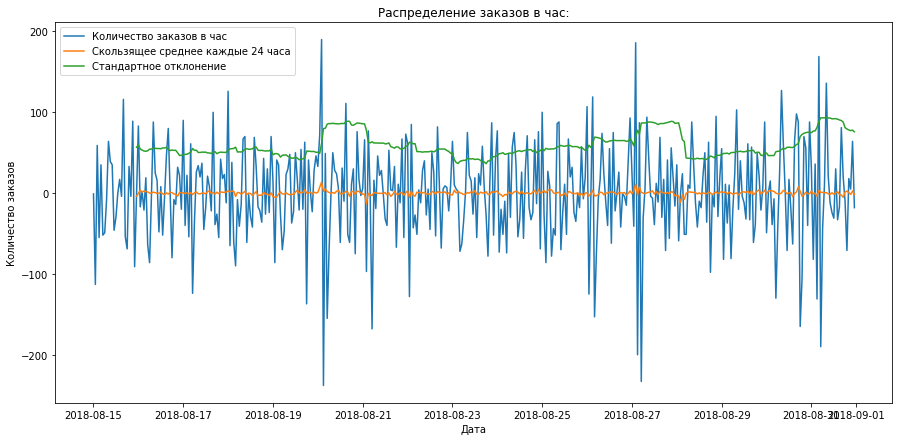

In [26]:
# разность временного ряда с 2018-08-15 по 2018-08-31:

df_shift = df - df.shift()

plt.figure(figsize=(15, 7))

plt.plot(df_shift['2018-08-15':'2018-08-31'])
plt.plot(df_shift['2018-08-15':'2018-08-31'].rolling(24).mean())
plt.plot(df_shift['2018-08-15':'2018-08-31'].rolling(24).std())

plt.title('Распределение заказов в час:')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

По графикам видно, что ряд стал стационарным.

На данном этапе проанализировали исходный ряд. Проанализировали следующие параметры:
    
    - скользящее среднее;
    - тренды и сезонность;
    - стационарность;
    - разности временного ряда.

После анализа пришли к выводу о том, что:
    
    - тренд постепенно растет;
    - сезонность стационарна;
    - ряд стационарен для периода с 2018-03 по 2018-08;
    - с 2018-08 и до окончания периода ряд не стационарен.  

## Обучение

[Назад к содержанию](#Содержание)

Перед нами стоит задача регрессии для временных рядов - необходимо спрогнозировать количество заказов такси на следующий час. 

Для решения можно применить следующие методы обучения модели:

  - дерево решений;
  - случайный лес в регрессии;
  - градиентный бустинг.


### Создание признаков

[Назад к содержанию](#Содержание)

Создадим признаки для горизонта прогнозирования в один шаг.

Напишем функцию для создания признаков. Разберём каждый тип признаков:

1. Календарные признаки
2. «Отстающие значения»
3. Скользящее среднее

Поскольку данные у нас за полгода и задача состоит в прогнозировании на 1 час, то для календарных признаков создадим следующие факторы: 

   - день недели;
   - час.

In [27]:
def make_features(df, max_lag, rolling_mean_size):
    
    # календарные признаки:
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # отстающие значения:
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    # скользящее среднее:
    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size).mean()
        
    return df


In [28]:
# создание новых признаков:

make_features(df, 1, 24)
print(df.head())

                     num_orders  dayofweek  hour  lag_1  rolling_mean
datetime                                                             
2018-03-01 00:00:00         124          3     0    NaN           NaN
2018-03-01 01:00:00          85          3     1  124.0           NaN
2018-03-01 02:00:00          71          3     2   85.0           NaN
2018-03-01 03:00:00          66          3     3   71.0           NaN
2018-03-01 04:00:00          43          3     4   66.0           NaN


### Создание выборок

[Назад к содержанию](#Содержание)

Создадим обучающую `train` и тестовую `test` выборки. Данные обучающей выборки должны предшествовать данным тестовой.

In [29]:
# создание обучающей и тестовой выборок:

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print('Обучающая выборка:')
display(train.head())
print('Тестовая выборка:')
display(test.head())

Обучающая выборка:


,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 23:00:00,58,3,23,113.0,56.833333
2018-03-02 00:00:00,90,4,0,58.0,55.416667
2018-03-02 01:00:00,120,4,1,90.0,56.875000
2018-03-02 02:00:00,75,4,2,120.0,57.041667
2018-03-02 03:00:00,64,4,3,75.0,56.958333


Тестовая выборка:


,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-08-13 14:00:00,102,0,14,119.0,138.458333
2018-08-13 15:00:00,175,0,15,102.0,139.541667
2018-08-13 16:00:00,144,0,16,175.0,139.166667
2018-08-13 17:00:00,152,0,17,144.0,140.708333
2018-08-13 18:00:00,104,0,18,152.0,141.791667


Чтобы убедиться в корректности деления выведем минимальные и максимальные значения индексов выборок. 

In [30]:
# минимальные и максимальные значения индексов выборок:

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [31]:
# размер выборок:

print(train.shape)
print(test.shape)


(3951, 5)
(442, 5)


Выборки разбиты верно.

Подготовим выборки с признаками и целевым признаком для обучения и тестирования моделей.

In [32]:
# выборка для обучения:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

# выборки для тестирования:
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']


In [33]:
# проверка размерностей выборок:

print('features_train:', features_train.shape)
print('target_train:', target_train.shape)
print('features_test:', features_test.shape)
print('target_test:', target_test.shape)


features_train: (3951, 4)
target_train: (3951,)
features_test: (442, 4)
target_test: (442,)


Выборки готовы для обучения моделей.

### Обучение моделей

[Назад к содержанию](#Содержание)

Обучим модели следующими способами:

   - с помощью `дерева решений в регрессии`;
   - с помощью `случайного леса в регрессии`;
   - с помощью библиотеки `CatBoost`.

Создадим переменные для хранения метрик качества обученных моделей.

In [34]:
# список с наименованиями обученных моделей:
models = []

# список для хранения RMSE на трейне
# при поиске оптимальных гиперпараметров
# с помощью GridSearchCV:
rmse_cv = []

# список для хранения RMSE на трейне
# модели с оптимальными гиперпараметрами: 
rmse_optimal = []

Далее создадим функцию `get_model` для поиска оптимальных гиперпараметров модели по сетке с помощью `GridSearchCV`. На вход функция будет получать модель, ее параметры для поиска оптимальных и наименование модели. А возвращать найденные наилучшие гиперпараметры, саму модель, `RMSE` на трейне.

In [35]:
# создаём функцию для обучения моделей и подбора гиперпараметров:

def search_params(model, parameters, model_name):
    
    tscv = TimeSeriesSplit(n_splits=8)
    search_model = GridSearchCV( \
            estimator=model,
            param_grid=parameters,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=tscv, 
            verbose=1)
        
    # обучение модели на тренировочной выборке:
    search_model.fit(features_train, target_train)
    
    # найденные оптимальные гиперпараметры:
    best_params = search_model.best_params_
    print('Оптимальные гиперпараметры модели:', best_params)
        
    # RMSE на тренировочной выборке после GridSearchCV:    
    grid_rmse = round(search_model.best_score_ * -1, 2)
    print('RMSE на тренировочной выборке после GridSearchCV:', grid_rmse)
    
    # сохранение результатов:
    # RMSE на трейне:
    rmse_cv.append(grid_rmse)
    
    # наименование модели
    models.append(model_name)
    
    return best_params, search_model, grid_rmse

Ещё создадим функцию `get_model` для обучения модели с найденными оптимальными гиперпараметрами после `GridSearchCV`.

In [36]:
def get_model(model):
    
    # обучение модели с оптимальными гиперпараметрами
    # на тренировочной выборке:
    model_optim = model.fit(features_train, target_train)

    # предсказания модели на тренировочной выборке:
    predict = model.predict(features_train)

    # вычисление RMSE:
    rmse = mse(target_train, predict, squared=False)
    print('RMSE модели на тренировочной выборке:', rmse)
    
    # сохранение результата:
    rmse_optimal.append(rmse)
    
    return model_optim, rmse

### Обучение модели с помощью дерева решений в регрессии.

[Назад к содержанию](#Содержание)

Сперва найдем по сетке оптимальные гиперпараметры модели. Для этого воспользуемся созданной функцией `search_params`.

In [37]:
%%time

# задание параметров для DecisionTreeRegressor:
dtr_params = {"max_depth": list(range(4, 10))}

# создание объекта типа DecisionTreeRegressor:
dtr = DecisionTreeRegressor()

# поиск модели с оптимальными гиперпараметрами и расчет RMSE:
dtr_best_params, search_dtr, grid_dtr_rmse = search_params(
                                                    dtr, 
                                                    dtr_params,
                                                    'DecisionTreeRegressor') 

Fitting 8 folds for each of 6 candidates, totalling 48 fits
Оптимальные гиперпараметры модели: {'max_depth': 8}
RMSE на тренировочной выборке после GridSearchCV: 27.91
CPU times: user 289 ms, sys: 4.24 ms, total: 293 ms
Wall time: 292 ms


Теперь заново обучим модель с найденными оптимальными гиперпараметрами. Применим функцию `get_model`.

In [38]:
%%time

# создание модели с оптимальными гиперпараметрами:
dtr = DecisionTreeRegressor(**dtr_best_params)

# обучение модели с оптимальными гиперпараметрами
# и вычисление RMSE на трейне:
dtr_optim, dtr_rmse = get_model(dtr)

RMSE модели на тренировочной выборке: 20.002627333601684
CPU times: user 9.53 ms, sys: 229 µs, total: 9.76 ms
Wall time: 8.8 ms


### Обучение модели с помощью случайного леса в регрессии

[Назад к содержанию](#Содержание)

Таким же образом подберём оптимальные гиперпараметры и вычислим ошибку для `RandomForestRegressor`.

In [39]:
%%time

# задание параметров для RandomForestRegressor:
rfr_params = {
    'n_estimators': [30, 50, 100, 150, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}

# создание объекта типа RandomForestRegressor:
rfr = RandomForestRegressor(n_jobs=-1)

# поиск модели с оптимальными гиперпараметрами и расчет RMSE:
rfr_best_params, search_rfr, grid_rfr_rmse = search_params(
                                                    rfr, 
                                                    rfr_params,
                                                    'RandomForestRegressor') 

Fitting 8 folds for each of 100 candidates, totalling 800 fits
Оптимальные гиперпараметры модели: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 150}
RMSE на тренировочной выборке после GridSearchCV: 23.88
CPU times: user 3min 43s, sys: 875 ms, total: 3min 43s
Wall time: 3min 44s


In [40]:
%%time

# создание модели с оптимальными гиперпараметрами:
rfr = RandomForestRegressor(**rfr_best_params)

# обучение модели с оптимальными гиперпараметрами
# и вычисление RMSE на трейне:
rfr_optim, rfr_rmse = get_model(rfr)

RMSE модели на тренировочной выборке: 16.20132586150456
CPU times: user 797 ms, sys: 0 ns, total: 797 ms
Wall time: 802 ms


### Обучение с помощью CatBoost

[Назад к содержанию](#Содержание)

Аналогично подберём наилучшие гиперпараметры и вычислим `RMSE` для `CatBoostRegressor`.

In [41]:
%%time

# задание параметров для CatBoost:

cat_params = {
    'learning_rate': [0.003, 0.01, 0.03],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 2, 3, 4],  
}

# создание объекта типа CatBoostRegressor:
cat = CatBoostRegressor(verbose=False) 

# поиск модели с оптимальными гиперпараметрами и расчет RMSE:
cat_best_params, search_cat, grid_cat_rmse, = search_params(
                                                        cat, 
                                                        cat_params,
                                                        'CatBoostRegressor')

Fitting 8 folds for each of 48 candidates, totalling 384 fits
Оптимальные гиперпараметры модели: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
RMSE на тренировочной выборке после GridSearchCV: 23.37
CPU times: user 10min 58s, sys: 23.8 s, total: 11min 22s
Wall time: 16min 18s


In [42]:
%%time

# создание модели с оптимальными гиперпараметрами:
cat = CatBoostRegressor(**cat_best_params, verbose=False)

# обучение модели с оптимальными гиперпараметрами
# и вычисление RMSE на трейне:
cat_optim, cat_rmse = get_model(cat)

RMSE модели на тренировочной выборке: 18.147319697290598
CPU times: user 1.87 s, sys: 94.2 ms, total: 1.96 s
Wall time: 2.71 s


### Анализ моделей

[Назад к содержанию](#Содержание)

Выведем метрики, полученные после обучения моделей. И выберем наилучшую модель.

In [43]:
# таблица с полученными результатами:
results = (pd.DataFrame({
                        'Модель':models,
                        'RMSE на трейне при GridSearchCV':rmse_cv,
                        'RMSE на трейне модели с оптим. параметрами':rmse_optimal,
                        }).sort_values(
                                by='RMSE на трейне модели с оптим. параметрами',
                                ascending=True).
                                reset_index(drop=True))

# вывод результатов:
results

,Модель,RMSE на трейне при GridSearchCV,RMSE на трейне модели с оптим. параметрами
0,RandomForestRegressor,23.88,16.201326
1,CatBoostRegressor,23.37,18.147320
2,DecisionTreeRegressor,27.91,20.002627


Ошибка `RMSE` модели с оптимальными гиперпараметрами меньше всего у модели, обученной с помощью `RandomForestRegressor`. Поэтому выберем эту модель в качестве наилучшей.

## Тестирование

[Назад к содержанию](#Содержание)

Протестируем наилучшую модель `RandomForestRegressor` на тестовой выборке. Вычислим значение ошибки `RMSE` на тестовой выборке.

In [44]:
# предсказания наилучшей модели RandomForestRegressor на тестовой выборке:
predict = rfr_optim.predict(features_test)

# вычисление RMSE:
rmse = mse(target_test, predict, squared=False)

print('RMSE у RandomForestRegressor на тестовой выборке:', rmse)

RMSE у RandomForestRegressor на тестовой выборке: 43.03136258379777


Для понимания насколько наилучшая модель хорошо предсказывает построим график предсказанных значений и фактических. Сперва построим для всего периода.

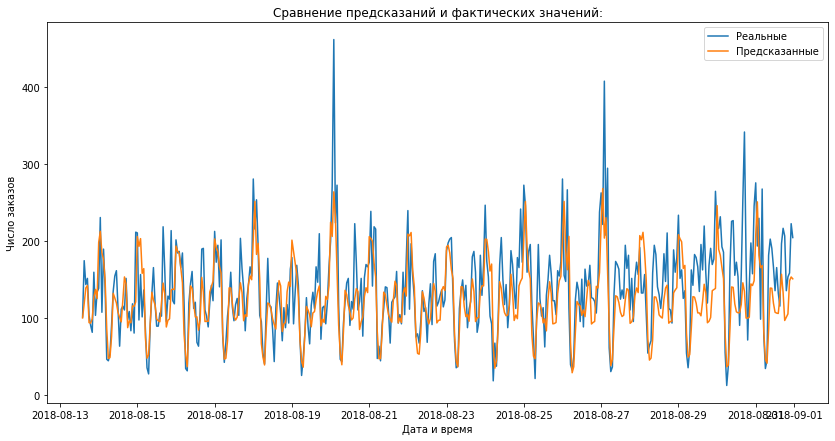

In [45]:
# вывод предсказанных и фактических значений числа заказов такси:

predict_df = pd.DataFrame(predict, index=features_test.index)

plt.figure(figsize=(14,7))

plt.plot(target_test)
plt.plot(predict_df)

plt.title('Сравнение предсказаний и фактических значений:')
plt.ylabel('Число заказов')
plt.xlabel('Дата и время')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

В целом модель повторяет контур реальных значений. Видно, что модель ошибается. Особенно заметно где встречаются всплески числа заказов такси - в этих промежутках модель "сглаживает" значения. 

Увеличим масштаб. Возьмем для примера два дня, чтобы можно было оценить ошибки прогнозирования по часам. 

In [46]:
# вывод диапазона тестовой выборки:

target_test.index.min(), target_test.index.max()

(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Возьмем период с `2018-08-15` по `2018-08-16`.

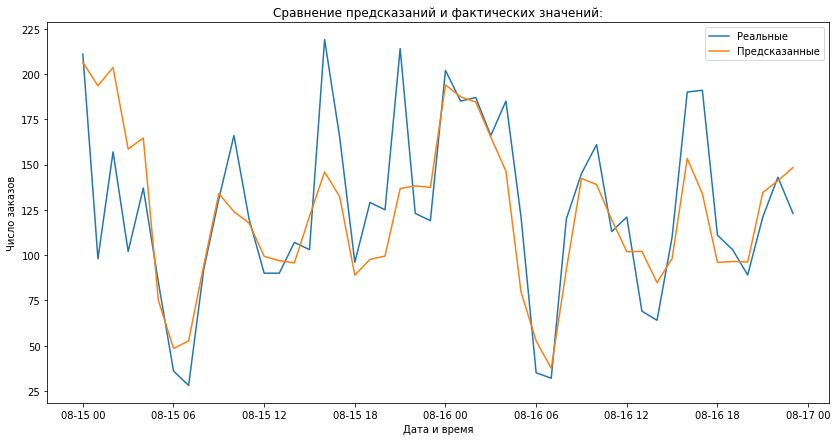

In [47]:
# вывод предсказанных и фактических значений числа заказов такси
# в период с 2018-08-15 по 2018-08-16:

predict_df = pd.DataFrame(predict, index=features_test.index)

plt.figure(figsize=(14,7))

plt.plot(target_test['2018-08-15':'2018-08-16'])
plt.plot(predict_df['2018-08-15':'2018-08-16'])

plt.title('Сравнение предсказаний и фактических значений:')
plt.ylabel('Число заказов')
plt.xlabel('Дата и время')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

На этом масштабе более заметны ошибки модели. Тем не менее, требуюмую точность предсказаний модель обеспечивает.

## Выводы

[Назад к содержанию](#Содержание)

В данной работе подобрали наилучшую модель для предсказания заказов такси на следующий час. 

Подбирали на основе трёх моделей, обученных с помощью:
    
   - дерева решений в регрессии;
   - случайного леса в регрессии;
   - библиотеки CatBoost.

Наилучшую метрику `RMSE` на тренировочной выборке получили для модели, обученной с помощью `случайного леса в регрессии`. Эту модель приняли в качестве наилучшей модели.

На тестовой выборке значение `RMSE` наилучшей модели составило:


In [48]:
rmse

43.03136258379777